
Sauce2
===

We step through the process of using the GPU to image the wavefront phase on to the wavefront sensor. We'll use OpenCL with batch FFTs.

In [49]:
%matplotlib notebook
from pyfft.cl import Plan
import numpy as np
import pyopencl as cl
import pyopencl.array as cl_array
from sauce2 import img
from sauce2 import dimg
import time
import tabulate
import astropy.units as u

Create a simulated Kolmogorov atmospheric phase screen using the `atmos` module.

In [12]:
from sauce2 import atmos
from sauce2.oprint import pprint
telescope = atmos.telescope # Shane telescope
print telescope
a = atmos.Screen(telescope=telescope)
a.pprint()

    fno = 17.0
    name = Shane 3m
    f = 51.0 m
    platescale = 4.044407965629341 arcsec / mm
    Ds = 0.8 m
    D = 3.0 m


    <class 'sauce2.atmos.Screen'>
------------------------------------------------------------
    ap = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0 ...
    du = 1.0 cm spatial grid sampling
    seeing =     seeing = 1.0313240312354819 arcsec
        theta0 = nan
        r0 = 10.0 cm
        wind_direction = 0.0 deg
        wind_magnitude = 10.0 m / s
        lam0 = 0.5 micron
        L0 = inf m
        wind_profile = 
        Cn2_profile = 
    
    telescope =     fno = 17.0
        name = Shane 3m
        f = 51.0 m
        platescale = 4.044407965629341 arcsec / mm
        Ds = 0.8 m
        D = 3.0 m
    
    n = 512



In [13]:
a.gen_screen()

<IPython.core.display.Javascript object>


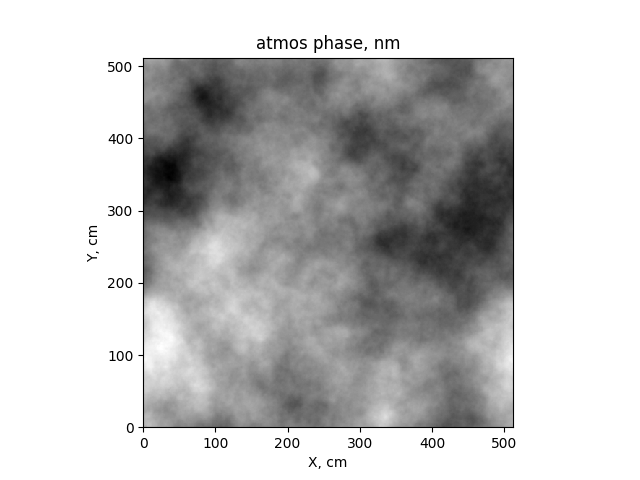

In [14]:
a.show()

In [15]:
pprint(a.screen)

Random Atmospheric Phase Screen
    <class 'astropy.units.quantity.Quantity'>    (512, 512)
------------------------------------------------------------
_unit:    Unit("nm") 'nm'
axis_names:    ('X', 'Y')
dx:    <Quantity 1. cm> 'spatial grid sampling'
longName:    'Random Atmospheric Phase Screen'
name:    'atmos phase'


We now want to define a set of subapertures on the screen.

In [22]:
a.telescope

    fno = 17.0
    name = Shane 3m
    f = 51.0 m
    platescale = 4.044407965629341 arcsec / mm
    Ds = 0.8 m
    D = 3.0 m

In [39]:
n_across = 14
d_tele = a.telescope.D
d_sec = a.telescope.Ds
d_subap = d_tele/n_across
n_subap = np.round((d_subap / a.screen.dx).decompose()).astype(int)
d_subap = n_subap*a.screen.dx
print 'subap_size = {0}'.format(d_subap)
print 'fine pixels across subap = {0}'.format(n_subap)
print 'the screen is {0} across'.format(a.n*a.du)

subap_size = 21.0 cm
fine pixels across subap = 21
the screen is 512.0 cm across


In [47]:
n_subap

<Quantity 21>

Create a list of subap objects. Initially this is a square grid.
Then trim those subaps with less than 50% illumination.

number of subaps = 150


<IPython.core.display.Javascript object>


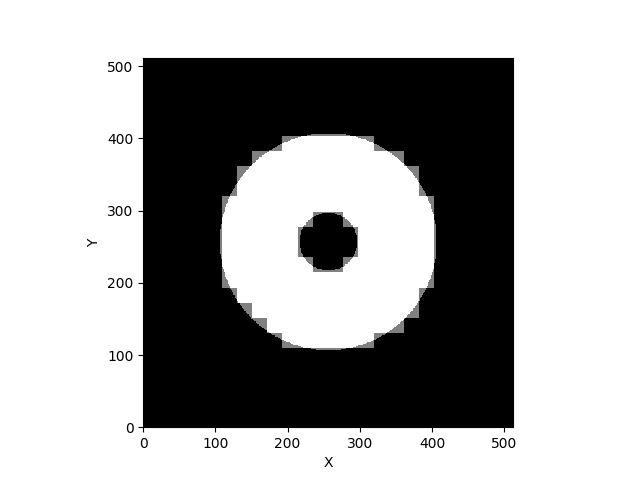

In [50]:
n = a.screen.shape[0]

# tag the lower-left positions of each candidate subap
xll = (np.arange(n_across)-n_across/2)*n_subap + a.n/2
yll = xll

# create an aperture (1's inside, 0's outside)
ap = img.circle((n,n),(n/2,n/2),r=((d_tele/2)/a.du).decompose())
ap -= img.circle((n,n),(n/2,n/2),r=((d_sec/2)/a.du).decompose())
# number the pixels in the screen according to raster-scan position
u = np.zeros((n,n)).astype(int)
u.flat = np.arange(n*n).astype(int)
# generate a list of groups of pixels, each group being all the pixels in the subap
subaps = []
for x in xll:
    for y in yll:
        pix = u[x:x+n_subap,y:y+n_subap].flatten()
        subaps.append(pix)
a_subap = n_subap*n_subap
# now filter out those subaps that aren't sufficiently illuminated
q = []
for subap in subaps:
    pc = ap.flat[subap].sum()/a_subap
    if pc > 0.5:
        q.append(subap)
subaps = q
n_subaps = len(subaps)

# lets check it by numbering the pixels by subap
v = np.zeros((n,n))
for k,subap in zip(range(n_subaps),subaps):
    v.flat[subap] = 1
v += ap
#v = info_array.InfoArray(v,name='ap + subaps',dx=a.du,dx_units='meters')
print 'number of subaps = {0}'.format(n_subaps)
dimg.show(v)

Each subap now has a list of pixel locations. These are used to indirectly address
the phase screen to pick out those phase data that are relevant to the subap. We
want to put these into arrays with a zero-pad in preparation for the FFT. So we need to create
one more set of pixel locations, the target locations on the zero-padded array.

In [51]:
n2 = 32 # zero-padded array size
u = np.ones((n_subap,n_subap)).astype(int)
u = img.zeropad(u,(n2,n2))
indt = np.where(u.flatten()==1)[0]
indts = []
offset = n2*n2
for k in range(n_subaps):
    indts.append(indt+k*offset)
indts = np.array(indts).flatten() # one big list of flat indices of the destination array

We now load the data into an array format that can be used by the GPU

In [52]:
indfs = np.array(subaps).flatten() # this is now a list of indices of the source array
data = np.ones((n_subaps,n2,n2),dtype=np.complex64)
# load the data from screen to formatted array
data.flat[indts] = a.screen.flat[indfs]

We now set up the GPU.

In [53]:
ctx = cl.create_some_context(interactive=False) # assumes environment variable PYOPENCL_CTX=':1'
queue = cl.CommandQueue(ctx)
plan = Plan((n2,n2),queue=queue)


<IPython.core.display.Javascript object>


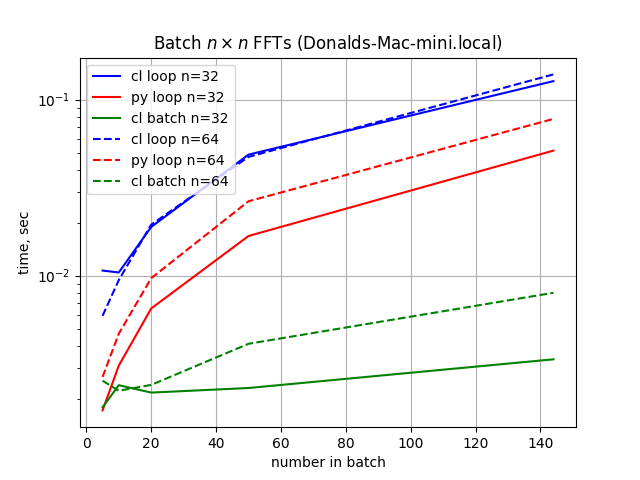

In [54]:
try:
    reload(demo_fft)
except:
    import demo_fft
demo_fft.graphit_batch(n=32,verbose=False,nfig=1)
demo_fft.graphit_batch(n=64,verbose=False,nfig=2)

Now editing demo_fft.py to gradually include all the steps in sauce.wfs - At 64x64 (n=64):

* no additional: 8 ms
* with exponentiation: 33 ms
* with exponentiation and square: 36 ms
* with square: 14 ms
* with 3 FFTs, exponentiation, square, multiply: 57 ms
* with 3 FFTs, exponentiation, square, multiply, readoff loop: 61 ms
* with 3 FFTs, exponentiation, square, multiply, readoff loop, indirect map: 61 ms
* there is one more operation not modeled, the extraction. This probably costs ~20 ms

cl_batch_wfs_test(n=64) profile results (times in milliseconds):


In [55]:
reload(demo_fft)
dummy = demo_fft.cl_batch_wfs_test(n=64,verbose=False)

indirect map

| operation               |   cum time | delta time   |
|:------------------------|-----------:|:-------------|
| start                   |        0   | 0.0          |
| exponentiation          |       28.7 | 28.7         |
| first FFT (computation) |       34.9 | 6.2          |
| first FFT (get result)  |       37   | 2.2          |
| square                  |       41.8 | 4.7          |
| 2nd square              |       48.4 | 6.6          |
| 2nd FFT                 |       57.5 | 9.1          |
| multiply                |       62   | 4.5          |
| 3ed FFT                 |       70.5 | 8.5          |
| readoff loop            |       79.3 | 8.8          |
| indirect map            |       81.1 | 1.8          |
| total                   |       82.9 |              |


| operation               |   cum time | delta time   |
|:------------------------|-----------:|:-------------|
| exponentiation          |       23.7 | 23.7         |
| first FFT (computation) |       29.2 | 5.5          |
| first FFT (get result)  |       30.8 | 1.6          |
| square                  |       37.1 | 6.4          |
| 2nd square              |       41.8 | 4.7          |
| 2nd FFT                 |       49.7 | 7.9          |
| multiply                |       51.3 | 1.7          |
| 3ed FFT                 |       59.3 | 8.0          |
| readoff loop            |       66.5 | 7.2          |
| indirect map            |       67.9 | 1.4          |
| total                   |       69.3 |              |

Here is the result of 50 profiles:

<IPython.core.display.Javascript object>


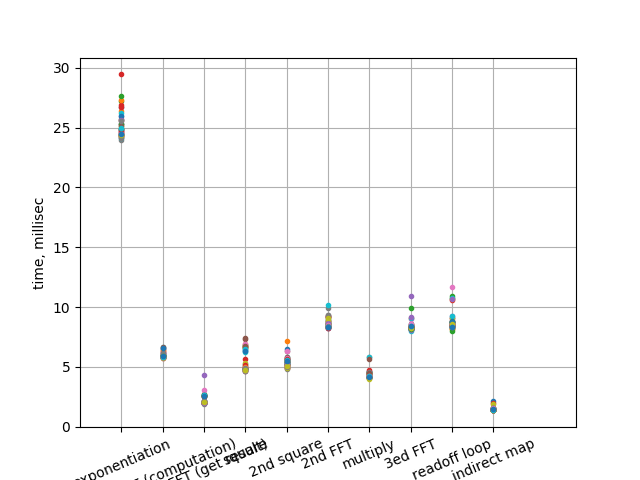

In [56]:
reload(demo_fft)
demo_fft.print_table = False
demo_fft.cl_batch_wfs_graph(n_trials=50,verbose=False)
demo_fft.print_table = True

**Conclusions**:

* reduce the cost of the exponentiation - try it in CL?, python using native sin, cos?
* readout loop should be down with an indirect (so also the extraction)
* reduce the cost of the square and the multiply - possibly combine all the FFTs, exp, square, and multiply into one OpenCL operation?


Continuing Lessons Learned
==========================

Implementing complex abs squared and complex multiply using OpenCL ...

* (see demo.py) each of these takes about 2 ms to operate on 144x64x64 data
* getting data in and out dominates:
    * cl.Buffer / cl.enqueue_copy takes 8 ms
    * cl_array.to_device / <data>_get takes only 3-4 ms (why?)
* can we follow one operation with another, without taking data out? - yes, this seems to work
* what about exponentiation?

The pyOpenCl API has a number of element-wise operations already defined
[pyOpenCL elementwise math functions](http://documen.tician.de/pyopencl/array.html#module-pyopencl.clmath)
Unfortunately, raw use of these swaps data in and out, defeating speed over multiple steps. (~100ms)
There is probably a way to deal with this, but I haven't learned how to do it yet:
[parallel algorithms]
(http://documen.tician.de/pyopencl/algorithm.html#module-pyopencl.elementwise)
In the mean time, I've coded the abs square and multiply as in-place operations in the kernel. Here are the results of the tests:

.. image:: https://bitbucket.org/donald_gavel/sauce/wiki/images/Figure4.png
   :alt: Figure4.png

d.cl_batch_wfs_graph(n_trials=30)

Final Times
===========

 ** average 17 ms ** , max 32 ms, min 12 ms


| operation    | cum time   |   delta time|
|:-------------|-----------:|:------------|
|start         |  0.00 ms   |    0.00 ms  |
|exponentiation|10.54 ms    |  10.54 ms   |
|1st FFT       |11.56 ms    |   1.01 ms   |
|abs square    |12.81 ms    |   1.25 ms   |
|2nd FFT       |13.11 ms    |   0.30 ms   |
|multiply      |14.52 ms    |   1.41 ms   |
|3ed FFT       |14.83 ms    |   0.30 ms   |


Dec 16, 2015
=======

Having now coded the complex exponent in CL kernel code, the whole thing runs considerably faster (it also passed the accuracy test). Exponent take 1.4 ms instead of 10 ms since it avoids swapping data in/out.

** ====> Need to get cl_batch_wfs_graph to run and give 50-trial average, max, and min HERE **

<cl_test> ===================== start ===========================
<pyopencl.Context at 0x7fc8413b5770 on <pyopencl.Device 'HD Graphics 4000' on 'Apple' at 0x1024400>>
 mapping done in  GPU
--------- Summary, Commparison of GPU to CPU -----------------
|          |   n_trials |   Total, sec |   Average, sec |
|:---------|-----------:|-------------:|---------------:|
| GPU time |         20 |     0.377959 |       0.018898 |
| CPU time |          1 |     0.120316 |       0.120316 |
------------------------ GPU timing profiles -------------------------
GPU Profiles of GPU operation steps (those steps available), last trial
| operation                     |   time, ms |
|:------------------------------|-----------:|
| zero-out the wavefront        |    0.2976  |
| move mag & phase to wavefront |    5.26208 |
| mag-phase to real-imag        |    0.4616  |
| abs square                    |    0.35192 |
| multiply                      |    0.6588  |
| zero ccd                      |    0.01888

<IPython.core.display.Javascript object>


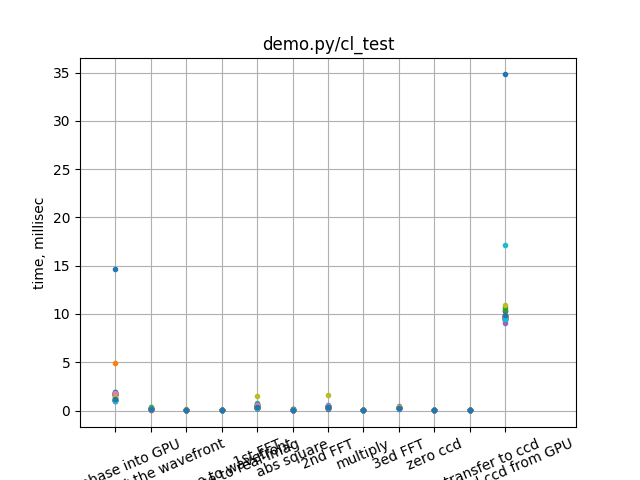

<cl_test> ===================== start ===========================
<pyopencl.Context at 0x7fc841312c60 on <pyopencl.Device 'HD Graphics 4000' on 'Apple' at 0x1024400>>
 mapping done in  GPU
--------- Summary, Commparison of GPU to CPU -----------------
|          |   n_trials |   Total, sec |   Average, sec |
|:---------|-----------:|-------------:|---------------:|
| GPU time |         20 |     0.26556  |       0.013278 |
| CPU time |          1 |     0.111026 |       0.111026 |
------------------------ GPU timing profiles -------------------------
GPU Profiles of GPU operation steps (those steps available), last trial
| operation                     |   time, ms |
|:------------------------------|-----------:|
| zero-out the wavefront        |    0.248   |
| move mag & phase to wavefront |    5.26688 |
| mag-phase to real-imag        |    0.43488 |
| abs square                    |    0.3484  |
| multiply                      |    0.59152 |
| zero ccd                      |    0.01952

In [19]:
execfile('demo.py')
cl_batch_wfs_graph(n_trials=30)

Dec 21, 2015
============

**A Few Lessons Learned**

* Taking course on http://handsonopencl.github.io
* Pull out the kernel (e.g. cmul = prg.cmul) so Python doesn't call clCreateKernel every time - can save 4-5 ms (p 79 of course lecture slides)
* Definitely do the memory indirect maps in the GPU. Can save 20ms (in+out). The GPU has to "learn" though. Run demo.cl_test_plot() to see the effect.
* Anxious to try the GPDMA in the Radeon 7100 - direct memory access to GPU could save ~10-15ms
* The `spec sheet <http://graphics-cards.specout.com/l/2459/Intel-HD-Graphics-4000>`_ says the memory bandwidth is 12 GB/s but it seems to be operating //much// slower than that in the transfers I've timed ~10 MB/s in the CCD transfer

In [16]:
ms = 0.001
T = 11.5981*ms
f = 1./T
print 'T=%2.1f ms runs at %2.1f Hz'%(T/ms,f)

T=11.6 ms runs at 86.2 Hz


<IPython.core.display.Javascript object>


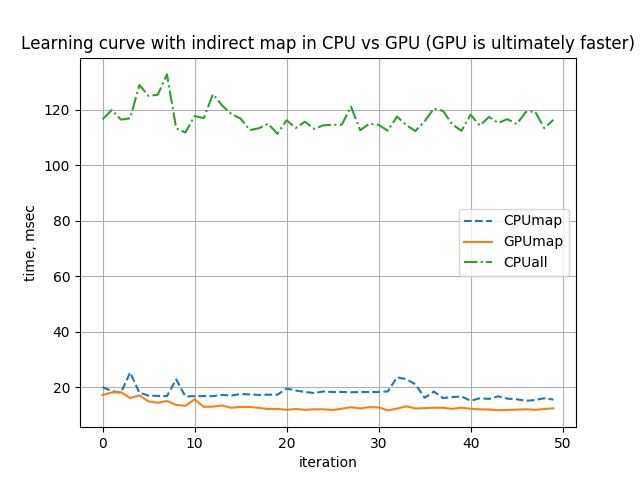

<cl_test> ===================== start ===========================
<pyopencl.Context at 0x7f96811f2710 on <pyopencl.Device 'HD Graphics 4000' on 'Apple' at 0x1024400>>
 mapping done in  CPU
--------- Summary, Commparison of GPU to CPU -----------------
|          |   n_trials |   Total, sec |   Average, sec |
|:---------|-----------:|-------------:|---------------:|
| GPU time |         50 |     0.889974 |      0.0177995 |
| CPU time |          1 |     0.135117 |      0.135117  |
------------------------ GPU timing profiles -------------------------
GPU Profiles of GPU operation steps (those steps available), last trial
| operation              |   time, ms |
|:-----------------------|-----------:|
| mag-phase to real-imag |    0.64744 |
| abs square             |    0.4064  |
| multiply               |    0.70288 |
CPU Clock timing of GPU operation steps, last trial
| operation                                           |   cum time, ms |   delta time, ms |
|:---------------------------

In [17]:
execfile('demo.py')
pylab.figure()
cl_test_plot()

### Summary, Commparison of GPU to CPU

|          |   n_trials |   Total, sec |   Average, sec |
|:---------|-----------:|-------------:|---------------:|
| GPU time |         50 |     0.837811 |      0.0167562 |
| CPU time |          1 |     0.131168 |      0.131168  |


GPU timing profiles
-------------------------
GPU Profiles of GPU operation steps (those steps available), last trial

| operation              |   time, ms |
|:-----------------------|-----------:|
| mag-phase to real-imag |    1.1084  |
| abs square             |    0.66512 |
| multiply               |    1.01688 |

CPU Clock timing of GPU operation steps, last trial

| operation                                           |   cum time, ms |   delta time, ms |
|:----------------------------------------------------|---------------:|-----------------:|
| start                                               |        0       |        0         |
| mag-phase copy-indirect in CPU and load into GPU    |        5.57184 |        5.57184   |
| mag-phase to real-imag                              |        5.62882 |        0.056982  |
| 1st FFT                                             |        6.07586 |        0.447035  |
| abs square                                          |        6.11496 |        0.0391006 |
| 2nd FFT                                             |        6.41203 |        0.29707   |
| multiply                                            |        6.44588 |        0.0338554 |
| 3ed FFT                                             |        6.72984 |        0.283957  |
| read out of GPU and copy indirect into CCD (python) |       18.5509  |       11.821     |

#### mapping done in  GPU
Summary, Commparison of GPU to CPU
-----------------

|          |   n_trials |   Total, sec |   Average, sec |
|:---------|-----------:|-------------:|---------------:|
| GPU time |         50 |     0.743361 |      0.0148672 |
| CPU time |         50 |     6.0548   |      0.121096  |

GPU timing profiles
-------------------------
GPU Profiles of GPU operation steps (those steps available), last trial

| operation                     |   time, ms |
|:------------------------------|-----------:|
| zero-out the wavefront        |    0.26272 |
| move mag & phase to wavefront |    4.99192 |
| mag-phase to real-imag        |    0.39648 |
| abs square                    |    0.34624 |
| multiply                      |    0.5852  |
| zero ccd                      |    0.01696 |
| indirct transfer to ccd       |    0.01688 |

CPU Clock timing of GPU operation steps, last trial

| operation                     |   cum time, ms |   delta time, ms |
|:------------------------------|---------------:|-----------------:|
| start                         |        0       |        0         |
| load phase into GPU           |        1.35183 |        1.35183   |
| zero-out the wavefront        |        1.46985 |        0.118017  |
| move mag & phase to wavefront |        1.51396 |        0.0441074 |
| mag-phase to real-imag        |        1.53184 |        0.0178814 |
| 1st FFT                       |        1.88589 |        0.354052  |
| abs square                    |        1.94097 |        0.0550747 |
| 2nd FFT                       |        2.17295 |        0.231981  |
| multiply                      |        2.22397 |        0.0510216 |
| 3ed FFT                       |        2.46596 |        0.241995  |
| zero ccd                      |        2.49481 |        0.0288486 |
| indirct transfer to ccd       |        2.51889 |        0.0240803 |
| unload ccd from GPU           |       12.3088  |        9.78994   |



Dec 23, 2015
============

It seems the "learning curves" change with repeated runs. The CPU indirect map
tends to lower values close to the GPU map, but never quite as low.

Also, looking in to the *Block Matrix* multiplication method - which gives a fantastically
fast multiply - (HandOnOpenCL). Run Exercise08, where I had to make the problem smaller 512 instead of
1024, possibly because of the small graphics GPU on the mac.
